In [1]:
import arbor as A
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Helper functions

**NOTE** You _can_ look at these, if you want, but they contain mainly unimportant details.

Use matplotlib to draw morphologies in 3d

In [51]:
def plot_morphology(mrf, *, fg=None):
    tree = mrf.to_segment_tree()
    colors = sns.color_palette('Set1')
    if not fg:
        fg = plt.figure(figsize=(10, 10))
    ax = fg.add_subplot(projection='3d')
    for seg in tree.segments:
        x0 = seg.prox.x
        x1 = seg.dist.x
        y0 = seg.prox.y
        y1 = seg.dist.y
        z0 = seg.prox.z
        z1 = seg.dist.z
        r0 = seg.prox.radius
        r1 = seg.dist.radius
        tag = seg.tag
    
        ax.plot(xs=[x0, x1], 
                ys=[y0, y1], 
                zs=[z0, z1], 
                color=colors[tag], 
                lw=(r0 + r1)) # average diameter from radius
    ax.set_xlabel(r'x $(\mu m)$')
    ax.set_ylabel(r'y $(\mu m)$')
    ax.set_zlabel(r'z $(\mu m)$')
    return fg, ax

Run a single cell model defined by morphology and decor and plot the membrane potential

In [107]:
def run_single_cell(mrf, dec):
    cell = A.cable_cell(mrf, dec)
    sim = A.single_cell_model(cell)
    sim.probe('voltage', where='(location 0 0.5)', frequency=10)
    sim.run(100)
    trace = sim.traces[0]

    fg, ax = plt.subplots()
    ax.plot(trace.time, trace.value)
    ax.set_ylim(-80, 40)
    ax.set_xlim(0, 100)
    ax.set_ylabel('$U/mV$')
    ax.set_xlabel('$t/ms$')

# Loading Morphologies

Morphologies describe the layout of a cell in 3d space. Arbor uses them to determine the electrical connections inside a cell in simulations. 
Most of the actual geometric information is _discarded_ during the setup, hence the name 'morphology'.

We can, however extract the geometry to visualize the input data using a simple helper and matplotlib.

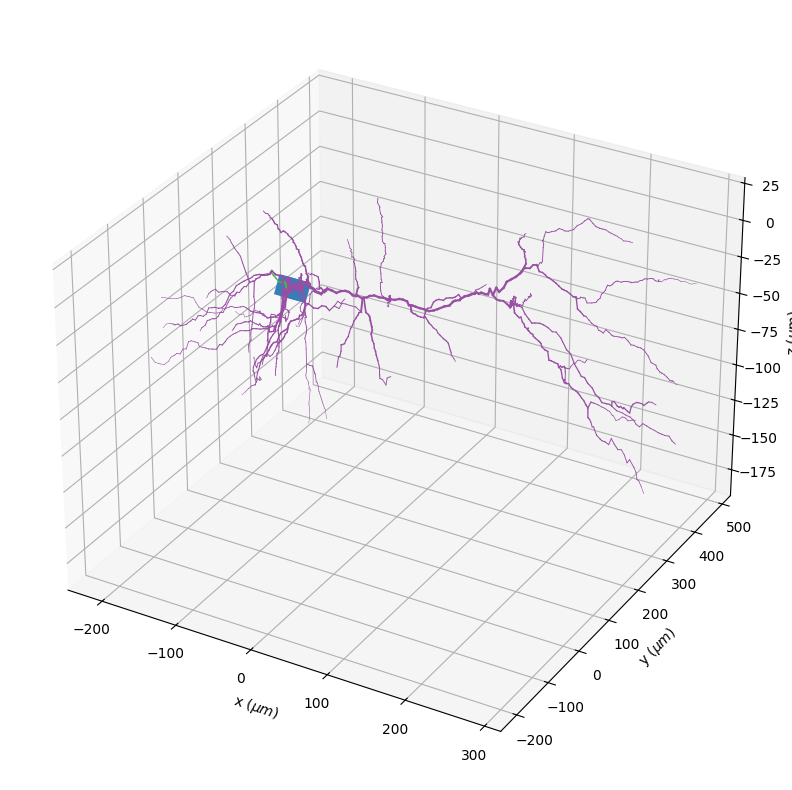

In [108]:
# SWC is a simple and common interchange format. We can load it in Arbor like this.
mrf = A.load_swc_neuron('Acker2008.swc')

fg = plt.figure(figsize=(10, 10))
fg, ax = plot_morphology(mrf, fg=fg)

Different colors denote regions of the cell that have been recorded during the segmentation process:

- soma
- basal dendrite
- apical dendrite
- axon

# From Morphologies to cells

A cell, as far as we are concerned at least, comprises two main things

- a morphology
- an assignment of parameters and dynamics

So far, this is likely very familiar. However, using Arbor, we can assign different dynamics to different subsets of the cell's surface.
For efficiency reasons, neither the morphology nor the assignments are performed on the actual simulated object. Rather, we construct
descriptions towards building a simulation which then is converted to an efficient simulation. This might feel a bit weird at first, 
but is extremely important for performance.

The assignment of parameters and dynamics is handled via the `decor`

In [109]:
dec = A.decor()

As we are handling a surface, two different kinds of operations are needed: one for point-like objects and one for sub-sections of the surface.
To assign objects with a finite extent, we use

In [110]:
dec.paint('(all)', Vm = -50) # set initial membrane potential in mV

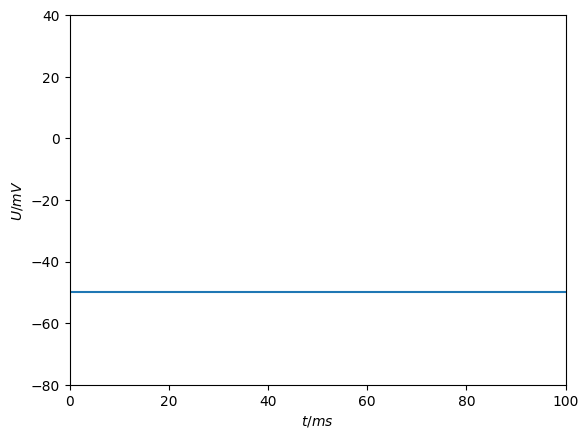

In [111]:
run_single_cell(mrf, dec)

Congratulations, at this point you have run your first simulation in Arbor. 

# Adding Dynamics

Certainly the last plot felt a bit underwhelming. Let's change that by adding an ion channel. We start with the simplest possible
model, a passive current.

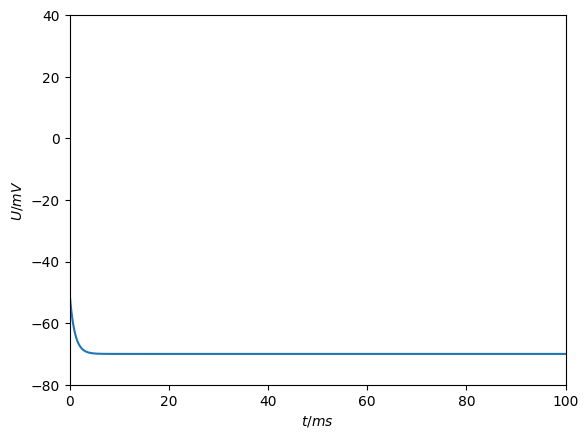

In [112]:
# we use a fresh decor here, as they are immutable objects.
dec = A.decor() 
dec.paint('(all)', Vm = -50)
# density indicates that we want an ion channel with a finite area
dec.paint('(all)', A.density('pas'))

run_single_cell(mrf, dec)

Before we move on, consider the first argument to `paint`. It specifies the locations _where_ things are added. 
Without going into an overwhelming amount of detail here, Arbor use a full DSL to precisely tune the locations
to your needs. Importantly, this is independent from the simulation and the cell's discretised form.

For now, we'll use only two expressions: `(all)`, meaning all of the cell's surface and `(location 0 0.5)` 
signifying the centre of the soma.

# Adding a Stimulus

Still, nothing much is happening in our model. We need to add an external stimulus, which brings us to the second 
use of `decor`. Point-like objects are added via `place`:

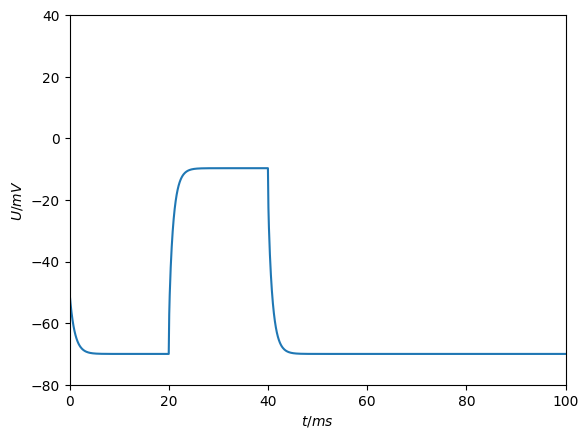

In [117]:
dec = A.decor() 
dec.paint('(all)', Vm = -50)
dec.paint('(all)', A.density('pas'))
dec.place('(location 0 0.5)', A.iclamp(tstart=20, duration=20, current=5), 'current')
run_single_cell(mrf, dec)

# TASK: Extending Cell Dynamics

Now, it's on you to make something more interesting happen. Using the schematic for constructing and running a single cell model above

1. Use a more elaborate ion channel, the Hodgkin-Huxley model. Add it to the whole cell instead of the passive current.
2. Tune the stimulus to produce two action potentials
3. Add a second stimulus $t=[60, 80)$ and make one more spike

# Solutions

You _can_ peek here to see how we solved it, if you need help. Or ask first.

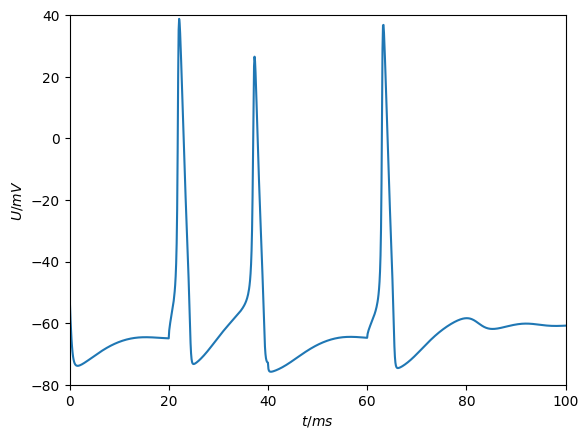

In [121]:
dec = A.decor() 
dec.paint('(all)', Vm = -50)
dec.paint('(all)', A.density('hh'))
dec.place('(location 0 0.5)', A.iclamp(tstart=20, duration=20, current=1), 'current')
dec.place('(location 0 0.5)', A.iclamp(tstart=60, duration=80, current=0.5), 'current')
run_single_cell(mrf, dec)